In [1]:
import re
import os
import glob
import zipfile
import requests
from urllib.request import urlretrieve
import json
import pandas as pd
import numpy as np
import plotly.express as px

# Downloading the data

The folder's path where the data is supposed to be stored

In [2]:
# Change the current working directory to the specified path
%cd /Users/mehdi/Downloads/MDS_Data

c:\Users\mehdi\Downloads\MDS_Data


Necessary MetaData

In [3]:
# Set the article ID for the desired article on figshare
article_id = 14096681  

# Set the URL for the figshare API, using the specified article ID
url = f"https://api.figshare.com/v2/articles/{article_id}"

# Set the headers for the HTTP request, indicating the type of content being sent
headers = {"Content-Type": "application/json"}

# Set the output directory for the data that will be retrieved from figshare
output_directory = "DSCI_525_rainfall/"

 a GET request to list the available files

In [4]:
# Send a GET request to the specified URL with the provided headers
response = requests.request("GET", url, headers=headers)

# Load the JSON response data into a Python dictionary using the json module
data = json.loads(response.text) 

# Extract the "files" key from the dictionary and assign it to the variable "files"
files = data["files"] 
files

[{'id': 26579150,
  'name': 'daily_rainfall_2014.png',
  'size': 58863,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26579150',
  'supplied_md5': 'fd32a2ffde300a31f8d63b1825d47e5e',
  'computed_md5': 'fd32a2ffde300a31f8d63b1825d47e5e'},
 {'id': 26579171,
  'name': 'environment.yml',
  'size': 192,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26579171',
  'supplied_md5': '060b2020017eed93a1ee7dd8c65b2f34',
  'computed_md5': '060b2020017eed93a1ee7dd8c65b2f34'},
 {'id': 26586554,
  'name': 'README.md',
  'size': 5422,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26586554',
  'supplied_md5': '61858c6cc0e6a6d6663a7e4c75bbd88c',
  'computed_md5': '61858c6cc0e6a6d6663a7e4c75bbd88c'},
 {'id': 26766812,
  'name': 'data.zip',
  'size': 814041183,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26766812',
  'supplied_md5': 'b517383f76e77bd03755a63a8f

In [5]:
%%time
# Measure the execution time of the code block

# List of files to be downloaded
files_to_dl = ["data.zip"]


for file in files:
    # Check if the current file is in the list of files to be downloaded
    if file["name"] in files_to_dl:
        # Create the output directory if it does not exist
        os.makedirs(output_directory, exist_ok=True)
        # Download the file from the download URL and save it to the output directory with its original name
        urlretrieve(file["download_url"], output_directory + file["name"])

CPU times: total: 5.53 s
Wall time: 1min 58s


In [6]:
%%time
# Measure the execution time of the code block

# Open the data.zip file in read mode
with zipfile.ZipFile(os.path.join(output_directory, "data.zip"), 'r') as f:
    # Extract all the contents of the zip file to the output directory
    f.extractall(output_directory)

CPU times: total: 21.7 s
Wall time: 1min 6s


# Combining data CSVs

In [7]:
%cd DSCI_525_rainfall/

c:\Users\mehdi\Downloads\MDS_Data\DSCI_525_rainfall


In [8]:
%%time
## here we are using a normal python way for merging the data 

files = glob.glob('*.csv')
if "observed_daily_rainfall_SYD.csv" in files:
    files.remove("observed_daily_rainfall_SYD.csv")

if "combined_data.csv" in files:
    os.remove("combined_data.csv")
    files.remove("combined_data.csv")
    
df = pd.concat((pd.read_csv(file, index_col=0)
                .assign(model=re.findall("([^_]*)", file)[0])
                for file in files)
              )
#df.to_csv("combined_data.csv")
with open("combined_data.csv", "w") as f:
    df.to_csv(f)

CPU times: total: 7min 21s
Wall time: 26min 22s


# Load the combined CSV to memory and perform a simple EDA

In [9]:
%%time
combined_df = pd.read_csv("combined_data.csv")
combined_df.memory_usage().sum()/1e6

CPU times: total: 1min 18s
Wall time: 3min 31s


3498.199336

In [10]:
combined_df.head(5)

,time,lat_min,lat_max,lon_min,lon_max,rain (mm/day),model
0,1889-01-01 12:00:00,-36.25,-35.0,140.625,142.5,3.293256e-13,ACCESS-CM2
1,1889-01-02 12:00:00,-36.25,-35.0,140.625,142.5,0.000000e+00,ACCESS-CM2
2,1889-01-03 12:00:00,-36.25,-35.0,140.625,142.5,0.000000e+00,ACCESS-CM2
3,1889-01-04 12:00:00,-36.25,-35.0,140.625,142.5,0.000000e+00,ACCESS-CM2
4,1889-01-05 12:00:00,-36.25,-35.0,140.625,142.5,1.047658e-02,ACCESS-CM2


### Changing dtype of your data

In [11]:
%%time
combined_df['rain (mm/day)'] = combined_df['rain (mm/day)'].astype(np.float16)
combined_df['lat_min'] = combined_df['lat_min'].astype(np.float16)
combined_df['lat_max'] = combined_df['lat_max'].astype(np.float16)
combined_df['lon_min'] = combined_df['lon_min'].astype(np.float16)
combined_df['lon_max'] = combined_df['lon_max'].astype(np.float16)
combined_df.memory_usage().sum()/1e6

CPU times: total: 4.56 s
Wall time: 10.9 s


1624.164046

### Load just columns that we want

In [14]:
%%time
use_cols = ['time','rain (mm/day)','model']
combined_rain = pd.read_csv("combined_data.csv",usecols=use_cols)
combined_rain.memory_usage().sum()/1e6

CPU times: total: 34.3 s
Wall time: 1min 53s


1499.22836

### Loading in chunks

In [16]:
%%time
counts = pd.Series(dtype=int)
for chunk in pd.read_csv("combined_data.csv", chunksize=10_000_000):
    counts = counts.add(chunk["model"].value_counts(), fill_value=0)
print(counts.astype(int))

ACCESS-CM2          1932840
ACCESS-ESM1-5       1610700
AWI-ESM-1-1-LR       966420
BCC-CSM2-MR         3035340
BCC-ESM1             551880
CMCC-CM2-HR4        3541230
CMCC-CM2-SR5        3541230
CMCC-ESM2           3541230
CanESM5              551880
EC-Earth3-Veg-LR    3037320
FGOALS-f3-L         3219300
FGOALS-g3           1287720
GFDL-CM4            3219300
GFDL-ESM4           3219300
INM-CM4-8           1609650
INM-CM5-0           1609650
KIOST-ESM           1287720
MIROC6              2070900
MPI-ESM-1-2-HAM      966420
MPI-ESM1-2-HR       5154240
MPI-ESM1-2-LR        966420
MRI-ESM2-0          3037320
NESM3                966420
NorESM2-LM           919800
NorESM2-MM          3541230
SAM0-UNICON         3541153
TaiESM1             3541230
dtype: int32
CPU times: total: 1min 29s
Wall time: 4min 2s


### performing a simple EDA

In [17]:
%%time
combined_rain['time'] = pd.to_datetime(combined_rain['time'])

CPU times: total: 36.4 s
Wall time: 2min 8s


In [18]:
%%time
df = pd.DataFrame(combined_rain.groupby([combined_rain['time'].dt.year, combined_rain['model']])['rain (mm/day)'].mean()).reset_index()

CPU times: total: 12.3 s
Wall time: 27.5 s


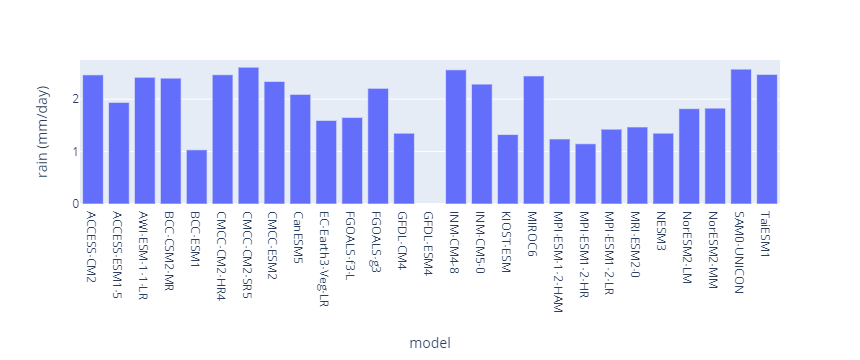

CPU times: total: 3.56 s
Wall time: 6.19 s


In [19]:
%%time
year = 2013
fig = px.bar(df[df['time']==year], x="model", y="rain (mm/day)")
fig.show()

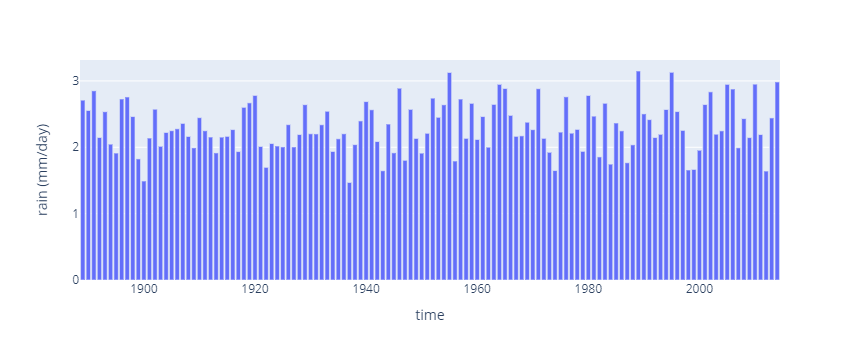

CPU times: total: 172 ms
Wall time: 416 ms


In [20]:
%%time
Model = "MIROC6"
fig = px.bar(df[df['model']==Model], x="time", y="rain (mm/day)")
fig.show()

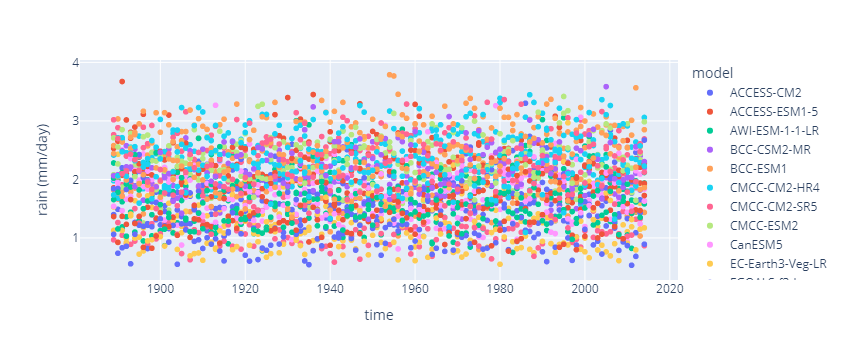

CPU times: total: 641 ms
Wall time: 1.22 s


In [21]:
%%time
fig = px.scatter(df, x="time", y="rain (mm/day)", color = "model")
fig.show()